In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210524'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:01, 10.20it/s]


(633996, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(631435, 20)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '강서구'
target_dong = '화곡동'
target_purpose = '2종일반'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(1509, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
37402,서울특별시 강서구 화곡동 354-42,강서로17다길 5-13,라테라스,59.33,33.67,38500,3,2017.0,3.0,2020-11-26,648.912860,4.0,대,160.8,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),강서구,화곡동
38802,서울특별시 강서구 화곡동 1049-19,화곡로23길 16,엠펠리체에이동,24.55,14.74,19250,6,2016.0,3.0,2019-11-29,784.114053,5.0,대,334.2,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),강서구,화곡동
38803,서울특별시 강서구 화곡동 1049-19,화곡로23길 16,엠펠리체에이동,27.87,16.73,21800,4,2016.0,4.0,2020-08-15,782.203086,5.0,대,334.2,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),강서구,화곡동
38804,서울특별시 강서구 화곡동 1049-19,화곡로23길 16,엠펠리체에이동,27.87,16.73,21500,4,2016.0,5.0,2021-02-17,771.438823,5.0,대,334.2,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),강서구,화곡동
41712,서울특별시 강서구 화곡동 59-32,까치산로10길 57-17,대동빌라(59-32),39.37,28.66,22500,3,2018.0,2.0,2020-02-26,571.501143,3.0,대,212.0,제2종일반주거지역,지정되지않음,주거기타,평지,정방형,세로한면(가),강서구,화곡동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(1509, 24)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
37402,서울특별시 강서구 화곡동 354-42,강서로17다길 5-13,라테라스,59.33,33.67,38500,3,2017.0,3.0,2020-11-26,648.912860,4.0,대,160.8,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),강서구,화곡동,667.994462,2021-03-01
38802,서울특별시 강서구 화곡동 1049-19,화곡로23길 16,엠펠리체에이동,24.55,14.74,19250,6,2016.0,3.0,2019-11-29,784.114053,5.0,대,334.2,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),강서구,화곡동,880.561029,2021-03-01
38803,서울특별시 강서구 화곡동 1049-19,화곡로23길 16,엠펠리체에이동,27.87,16.73,21800,4,2016.0,4.0,2020-08-15,782.203086,5.0,대,334.2,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),강서구,화곡동,840.609941,2021-03-01
38804,서울특별시 강서구 화곡동 1049-19,화곡로23길 16,엠펠리체에이동,27.87,16.73,21500,4,2016.0,5.0,2021-02-17,771.438823,5.0,대,334.2,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),강서구,화곡동,779.940417,2021-03-01
41712,서울특별시 강서구 화곡동 59-32,까치산로10길 57-17,대동빌라(59-32),39.37,28.66,22500,3,2018.0,2.0,2020-02-26,571.501143,3.0,대,212.0,제2종일반주거지역,지정되지않음,주거기타,평지,정방형,세로한면(가),강서구,화곡동,640.856020,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

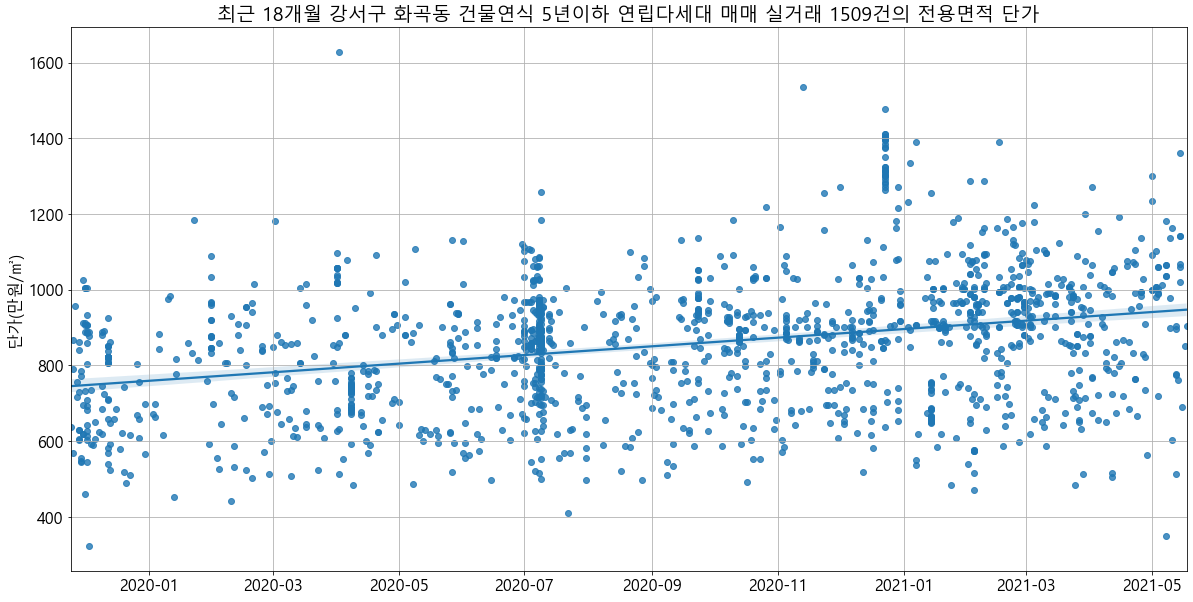

In [19]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [20]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

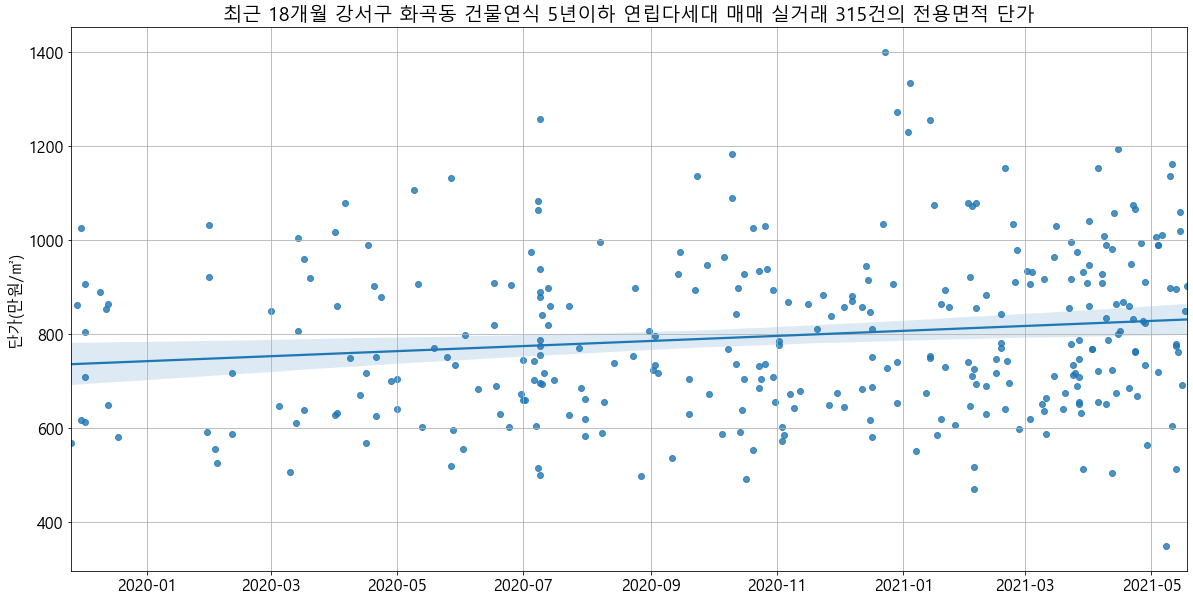

In [21]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [22]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [23]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(15675, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
37212,서울특별시 강서구 화곡동 1038-26,강서로37길 47,(1038-26),65.90,32.82,10600,2,2002.0,4.0,2006-07-05,160.849772,19.0,대,125.7,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),강서구,화곡동
37213,서울특별시 강서구 화곡동 1038-26,강서로37길 47,(1038-26),57.54,28.65,8800,5,2002.0,4.0,2006-09-08,152.937087,19.0,대,125.7,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),강서구,화곡동
37214,서울특별시 강서구 화곡동 1038-26,강서로37길 47,(1038-26),65.90,32.82,13200,3,2002.0,4.0,2006-12-15,200.303490,19.0,대,125.7,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),강서구,화곡동
37255,서울특별시 강서구 화곡동 1086-29,화곡로18길 47,(1086-29),64.46,43.54,8500,2,2001.0,5.0,2006-03-06,131.864722,20.0,대,237.5,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,중로한면,강서구,화곡동
37317,서울특별시 강서구 화곡동 166-26,강서로18아길 26-14,(166-26),72.52,37.64,10500,4,2004.0,2.0,2006-10-24,144.787645,17.0,대,283.3,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(가),강서구,화곡동


In [24]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'강서구 화곡동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 15675건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

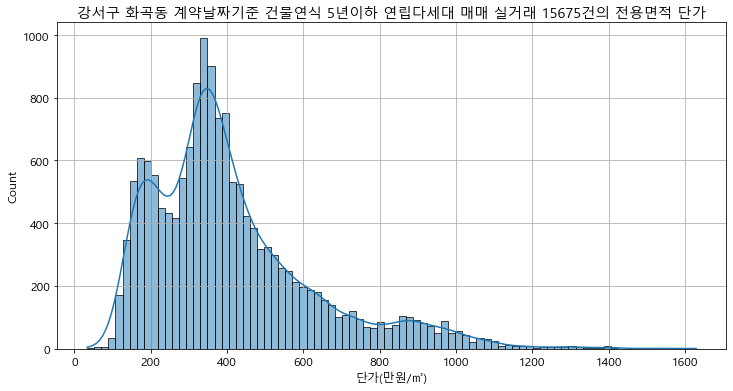

In [25]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [26]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [27]:
concat_df = pd.concat([target_df2])

In [28]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [29]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [30]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(8359, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 강서구 화곡동 100-21,초록마을로6길 37-8,복지홈타운(100-21),46.19,31.25,20300,2,2002.0,5.0,2007-01-03,439.489067,19.0,대,407.0,제2종일반주거지역,지정되지않음,다세대,완경사,자루형,세로한면(가),강서구,화곡동,817.130628,2021-03-01,401.203454,687.350045
1,서울특별시 강서구 화곡동 100-21,초록마을로6길 37-8,복지홈타운(100-21),47.86,32.39,20000,4,2002.0,5.0,2007-06-14,417.885499,19.0,대,407.0,제2종일반주거지역,지정되지않음,다세대,완경사,자루형,세로한면(가),강서구,화곡동,711.119296,2021-03-01,401.203454,687.350045
2,서울특별시 강서구 화곡동 100-21,초록마을로6길 37-8,복지홈타운(100-21),56.32,38.11,19500,4,2002.0,5.0,2007-11-24,346.235795,19.0,대,407.0,제2종일반주거지역,지정되지않음,다세대,완경사,자루형,세로한면(가),강서구,화곡동,533.800211,2021-03-01,401.203454,687.350045
3,서울특별시 강서구 화곡동 100-22,초록마을로6길 47,청성스카이,58.45,32.86,17800,5,2009.0,0.0,2009-04-08,304.533790,12.0,대,307.0,제2종일반주거지역,지정되지않음,다세대,완경사,자루형,세로한면(가),강서구,화곡동,433.060203,2021-03-01,279.059621,396.312627
4,서울특별시 강서구 화곡동 100-22,초록마을로6길 47,청성스카이,59.15,33.25,19500,4,2009.0,3.0,2012-03-02,329.670330,12.0,대,307.0,제2종일반주거지역,지정되지않음,다세대,완경사,자루형,세로한면(가),강서구,화곡동,459.899693,2021-03-01,279.059621,396.312627


In [31]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(3002, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
2,서울특별시 강서구 화곡동 100-21,초록마을로6길 37-8,복지홈타운(100-21),56.32,38.11,19500,4,2002.0,5.0,2007-11-24,346.235795,19.0,대,407.0,제2종일반주거지역,지정되지않음,다세대,완경사,자루형,세로한면(가),강서구,화곡동,533.800211,2021-03-01,401.203454,687.350045
7,서울특별시 강서구 화곡동 100-22,초록마을로6길 47,청성스카이,79.93,44.93,20500,3,2009.0,5.0,2014-05-07,256.474415,12.0,대,307.0,제2종일반주거지역,지정되지않음,다세대,완경사,자루형,세로한면(가),강서구,화곡동,377.724527,2021-03-01,279.059621,396.312627
10,서울특별시 강서구 화곡동 100-28,초록마을로6길 37-12,복지홈타운2동,49.12,23.19,15400,3,2002.0,5.0,2007-03-15,313.517915,19.0,대,225.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로한면(가),강서구,화곡동,571.203935,2021-03-01,308.055841,522.162596
12,서울특별시 강서구 화곡동 100-36,초록마을로6길 37-10,복지홈타운3동,46.73,23.72,12500,3,2002.0,4.0,2006-10-20,267.494115,19.0,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로한면(가),강서구,화곡동,538.995231,2021-03-01,238.429633,480.430887
15,서울특별시 강서구 화곡동 1007-5,강서로45다길 7,트라움빌,66.11,37.94,33500,6,2012.0,2.0,2014-11-18,506.731206,9.0,대,853.8,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),강서구,화곡동,744.779981,2021-03-01,571.281235,770.694002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8344,서울특별시 강서구 화곡동 997-15,우장산로14길 35,아인스빌(997-15),37.67,16.98,16450,4,2011.0,5.0,2016-03-14,436.687019,10.0,대,224.1,제3종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),강서구,화곡동,594.391262,2021-03-01,441.605542,600.454555
8345,서울특별시 강서구 화곡동 997-20,우장산로14길 27,대성탑스빌에이동(997-20),57.36,34.43,17700,2,2004.0,4.0,2008-04-13,308.577406,17.0,대,258.0,제3종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),강서구,화곡동,409.677066,2021-03-01,308.577406,409.677066
8348,서울특별시 강서구 화곡동 997-25,화곡로55길 11-4,랜드하우스,29.92,22.75,21000,2,2016.0,4.0,2020-07-16,701.871658,5.0,대,195.0,제3종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),강서구,화곡동,754.435237,2021-03-01,970.393178,1244.278533
8349,서울특별시 강서구 화곡동 997-31,우장산로14길 29,대성탑스빌비동(997-31),42.52,28.00,13800,4,2004.0,4.0,2008-08-22,324.553151,17.0,대,112.0,제3종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),강서구,화곡동,426.818802,2021-03-01,324.553151,426.818802


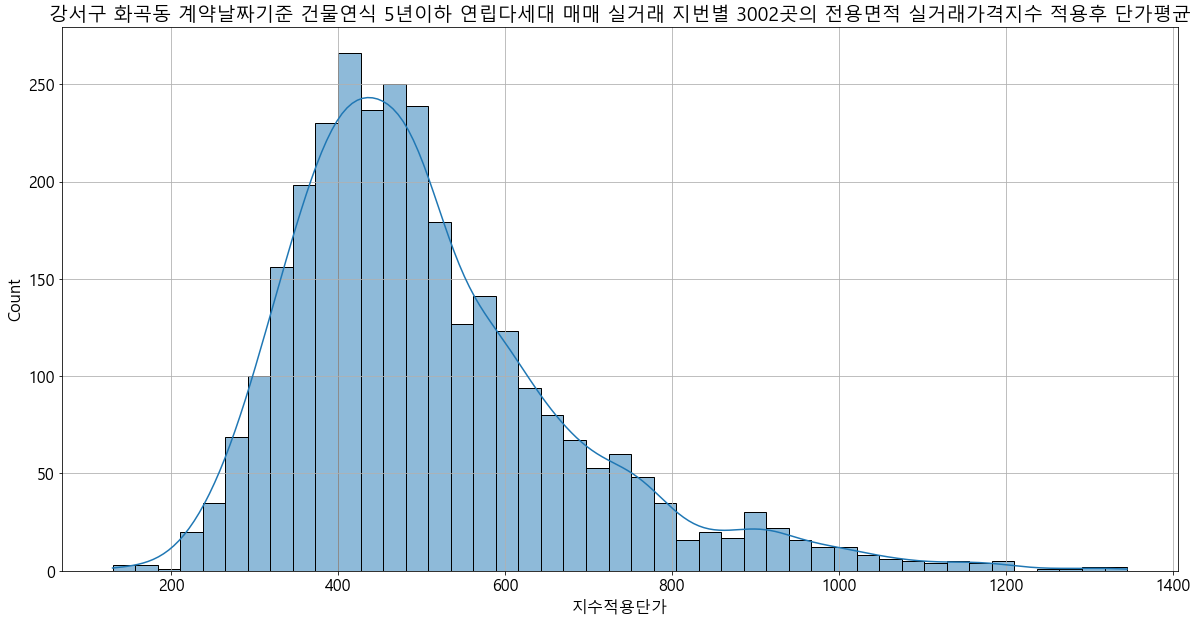

In [32]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [33]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [34]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1
0,서울특별시 강서구 화곡동 100-21,복지홈타운(100-21),2002.0,56.32,2007-11-24,346.235795,2021-03-01,533.800211,제2종일반주거지역
1,서울특별시 강서구 화곡동 100-22,청성스카이,2009.0,79.93,2014-05-07,256.474415,2021-03-01,377.724527,제2종일반주거지역
2,서울특별시 강서구 화곡동 100-28,복지홈타운2동,2002.0,49.12,2007-03-15,313.517915,2021-03-01,571.203935,제2종일반주거지역
3,서울특별시 강서구 화곡동 100-36,복지홈타운3동,2002.0,46.73,2006-10-20,267.494115,2021-03-01,538.995231,제2종일반주거지역
4,서울특별시 강서구 화곡동 1007-5,트라움빌,2012.0,66.11,2014-11-18,506.731206,2021-03-01,744.779981,제2종일반주거지역


In [35]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)